In [117]:
import pandas as pd
import matplotlib.pyplot as plt
import gensim.parsing.preprocessing as gen_preproc

import spacy
nlp = spacy.load('en_core_web_sm')

import numpy as np
from gensim.models import FastText
from gensim.models import Word2Vec
from nltk.tokenize import sent_tokenize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix

from sklearn import svm

## Data Preview & Basic Cleanup

Simple open the file and preview the basic data in the training set.

In [115]:
df = pd.read_csv( 'parsed_train.txt', sep='\t', header=None,
                   names=['label', 'text'] )
df.head()

,label,text
0,__label__4,The Rock is destined to be the 21st Century 's...
1,__label__5,The gorgeously elaborate continuation of `` Th...
2,__label__4,Singer/composer Bryan Adams contributes a slew...
3,__label__3,You 'd think by now America would have had eno...
4,__label__4,Yet the act is still charming here .


Do some basic cleanup of labels, not yet preprocessing the text at all.

In [116]:
df['label'] = df['label'].apply(lambda x: int( x.replace("__label__", "") ) )

df.head()

,label,text
0,4,The Rock is destined to be the 21st Century 's...
1,5,The gorgeously elaborate continuation of `` Th...
2,4,Singer/composer Bryan Adams contributes a slew...
3,3,You 'd think by now America would have had eno...
4,4,Yet the act is still charming here .


#### Are my labels balanced and evenly distributed? 

Or do I need to pay special care to my input data?

(array([1092., 2218., 1624., 2322., 1288.]),
 array([1, 2, 3, 4, 5, 6]),
 <BarContainer object of 5 artists>)

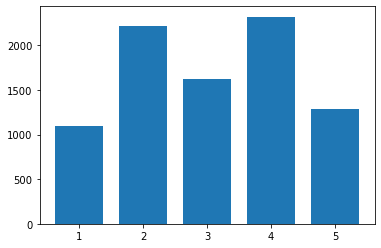

In [20]:
plt.hist(df['label'], bins=[1,2,3,4,5,6], align='left', rwidth=0.75)

A bit unbalanced, but not too much. Also a symetrical distrobution, not many extra positive or negative reviews; though theres slight more positive items.

#### How many reviews are more than a single sentence?

When getting to embedding models, can I treat each item as a single sentence?

## Preprocessing

Time to do a bit of preprocessing for different items. All items will be lowercase, punctuation & stop words stripped as well as some other basic preprocessing; plus one column thats stemmed and another lemmatized.

In [80]:
basicPreproc = [lambda x: x.lower(), gen_preproc.strip_tags, \
    gen_preproc.strip_punctuation, gen_preproc.strip_non_alphanum, \
    gen_preproc.strip_multiple_whitespaces] #, gen_preproc.strip_short, gen_preproc.remove_stopwords

df['basicProc'] = df['text'].apply(lambda x: ' '.join( gen_preproc.preprocess_string(x, basicPreproc)))
df['stemmed'] = df['basicProc'].apply(lambda x: gen_preproc.stem_text(x))
df['lemmatized'] = df['basicProc'].apply(lambda x: ' '.join( [token.lemma_ for token in nlp(x)] ) )

df.head()

,label,text,basicProc,stemmed,lemmatized,tokenized
0,4,The Rock is destined to be the 21st Century 's...,the rock is destined to be the 21st century s ...,the rock is destin to be the 21st centuri s ne...,the rock be destine to be the 21st century s n...,"[the, rock, destine, the, 21st, century, new, ..."
1,5,The gorgeously elaborate continuation of `` Th...,the gorgeously elaborate continuation of the l...,the gorgeous elabor continu of the lord of the...,the gorgeously elaborate continuation of the l...,"[the, gorgeously, elaborate, continuation, the..."
2,4,Singer/composer Bryan Adams contributes a slew...,singer composer bryan adams contributes a slew...,singer compos bryan adam contribut a slew of s...,singer composer bryan adams contribute a slew ...,"[singer, composer, bryan, adams, contribute, s..."
3,3,You 'd think by now America would have had eno...,you d think by now america would have had enou...,you d think by now america would have had enou...,-PRON- d think by now america would have have ...,"[-PRON-, think, now, america, would, have, hav..."
4,4,Yet the act is still charming here .,yet the act is still charming here,yet the act is still charm here,yet the act be still charm here,"[yet, the, act, still, charm, here]"


## Creating BOW-Esk Input Vectors & Models

In [81]:
bowVec = CountVectorizer(binary=True, ngram_range=(1,2), min_df=2, max_features=5000)
cvVec = CountVectorizer(binary=False, ngram_range=(1,2), min_df=2, max_features=5000)
tfidfVec = TfidfVectorizer(ngram_range=(1,2), min_df=2, max_features=5000)

bowDTM = bowVec.fit_transform(df['lemmatized'])
cvDTM = cvVec.fit_transform(df['lemmatized'])
tfidfDTM = tfidfVec.fit_transform(df['lemmatized'])

In [82]:
bowModel = svm.SVR()
cvModel = svm.SVR()
tfidfModel = svm.SVR()

bowModel.fit(bowDTM, df['label'])
cvModel.fit(cvDTM, df['label'])
tfidfModel.fit(tfidfDTM, df['label'])

SVR()

## Load in the Test Dataset And Parse the same way as Train

In [83]:
test_df = pd.read_csv( 'parsed_test.txt', sep='\t', header=None,
                   names=['label', 'text'] )
test_df['label'] = test_df['label'].apply(lambda x: int( x.replace("__label__", "") ) )
test_df['basicProc'] = test_df['text'].apply(lambda x: ' '.join( gen_preproc.preprocess_string(x, basicPreproc)))
test_df['stemmed'] = test_df['basicProc'].apply(lambda x: gen_preproc.stem_text(x))
test_df['lemmatized'] = test_df['basicProc'].apply(lambda x: ' '.join( [token.lemma_ for token in nlp(x)] ) )

test_df.head()

,label,text,basicProc,stemmed,lemmatized
0,3,Effective but too-tepid biopic,effective but too tepid biopic,effect but too tepid biopic,effective but too tepid biopic
1,4,If you sometimes like to go to the movies to h...,if you sometimes like to go to the movies to h...,if you sometim like to go to the movi to have ...,if -PRON- sometimes like to go to the movie to...
2,5,"Emerges as something rare , an issue movie tha...",emerges as something rare an issue movie that ...,emerg as someth rare an issu movi that s so ho...,emerge as something rare an issue movie that s...
3,3,The film provides some great insight into the ...,the film provides some great insight into the ...,the film provid some great insight into the ne...,the film provide some great insight into the n...
4,5,Offers that rare combination of entertainment ...,offers that rare combination of entertainment ...,offer that rare combin of entertain and educ,offer that rare combination of entertainment a...


## BOW - Esk Evaluation

In [84]:
testBowDTM = bowVec.transform( test_df['lemmatized'] )
testCvDTM = cvVec.transform( test_df['lemmatized'] )
testTfidfDTM = tfidfVec.transform( test_df['lemmatized'] )

In [85]:
print( 'Bow R^2: ',  bowModel.score(testBowDTM, test_df['label']) )
print( 'Cv R^2: ',  cvModel.score(testCvDTM, test_df['label'])  )
print( 'Tfidf R^2: ',  tfidfModel.score(testTfidfDTM, test_df['label'])  )

Bow R^2:  0.33200996559026075
Cv R^2:  0.3229852810198336
Tfidf R^2:  0.3627280831959865


Fairly Comparable results. Probably impacted by the fact that each text is relatively short. We didn't do any analysis of our actual vectorizer's here; technically we did keep max 5k vocab words but we don't know if we even hit that many. We don't know how sparse our input vectors are either. We could almost certainly improve these results (and maybe show more distinction between items) if we made our vectorizers more dense using something like PCA (principle component analysis) or SVD (singular value decomposition). We'll look at those & preproc steps affects if time allows.

## Embedding Model Time

Here we are treating each doc (since they are very short) as a single sentence, just for simplicity. If time allows, we'd check this in the data exploration step.

In [86]:
df['tokenized'] = df['lemmatized'].apply(lambda x: x.split())
w2vModel = Word2Vec( df['tokenized'], vector_size=100, window=5, min_count=3, workers=10)
w2vSvmModel = svm.SVR()

In [112]:
vocab = list(w2vModel.wv.index_to_key)

#Turns out with stop word removal some items have 0 words so deleted that out of preprocessing.
#Also turns out some items only have 2 word phrases, so deleted that out of preprocessing.
badsDf = df[df['tokenized'].apply(lambda x: len(x) < 1)] 
badsDf.head()

def calc_vec(tokensLst):
    vecs = [w2vModel.wv[word] for word in tokensLst if word in vocab]
    if len(vecs) == 0:
        vecs = [np.zeros(100), np.zeros(100)]
    return sum(vecs) / max([len(tokensLst), 1])

df['w2vVectors'] = df['tokenized'].apply(lambda x: calc_vec(x))
X = list( df['w2vVectors'] )
y = list( df['label'] )

w2vSvmModel.fit( X, y )

SVR()

In [118]:
test_df['tokenized'] = test_df['lemmatized'].apply(lambda x: x.split())
test_df['w2vVectors'] = test_df['tokenized'].apply(lambda x: calc_vec(x))
testX = list( test_df['w2vVectors'] )
testy = list( test_df['label'] )
testPredy = w2vSvmModel.predict( testX )
w2vSvmModel.score( testX, testy )

0.03447150574248681

Interestingly, much worse performance than the non-embedding models. I wonder why?

## To Do:

- Examine using PCA & SVD w. BOW-esk models
- Try FastText
- Figure out how many reviews are a single sentence
- Compare results of stemming instead of lemmatization
- Use RMSE in addition to R^2 
- Use confusion Matrices
- Look at distro of lengths of reviews
- Include pretrained vectors